In [1]:
%matplotlib inline
import numpy as np
import emilys.optics.aperture as ap
import emilys.optics.mtf as mtf
import emilys.image.arrayplot as aplt
import matplotlib.pyplot as plt
import scipy.optimize as opt
from tqdm.autonotebook import tqdm
import time

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# this calculates an aperture on a grid with mtf convolution
# aperture values are 1 for full transmission
def simulate_aperture(array, mtfkern, pos, qsamp, qcenter, qrad, qsmooth, qdistortion):
    # calculate an aperture grid
    ap.aperture_dist3_grid(array, pos, qsamp, qcenter, qrad, qsmooth, qdistortion)
    # resample the squared image on bins with MTF
    array[...] = np.real( np.fft.ifft2( np.fft.fft2(array * array) * mtfkern ) )
    return 0
def aperture_image_sdif(image_ref, image_sim, image_msk, mtfkern, qsamp, params):
    nprm = params.size
    c = np.array([0.,0.])
    # simulate an aperture image
    simulate_aperture(image_sim, mtfkern, params[0:2], qsamp, c, params[2], params[3], params[4:nprm])
    tsim = np.sum(image_sim) # get total simulated intensity
    image_sim[...] = image_sim / tsim # normalize and set
    return np.sum(((image_sim - image_ref)**2 * image_msk)) # return squared difference of masked pixels   

In [3]:
# ! Set the working directory for helping to locate input and output files on yur local drive !
sworkdir = '../data/'

- number of mtf values:  129
- Nyquist index:  127
- extrapolation to f = 1.0 , index = 257


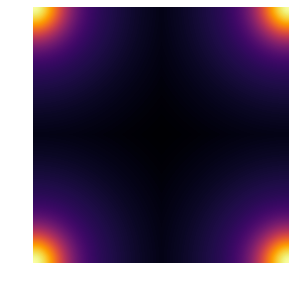

In [4]:
# experimental parameters
ndim = np.array([256,256]) # image dimensions
arot = -12.1/180.*np.pi # image sampling back-rotation
rm = np.array([[np.cos(arot), -np.sin(arot)], [np.sin(arot), np.cos(arot)]]) # rotation matrix
sq1 = np.array([[0.264025, 0.000831018],[0., 0.263445]]) # sampling matrix
sq2 = np.dot(rm,sq1) # final sampling matrix
q0 = np.array([0.,0.]) # aperture shift
p0 = np.array([127.,127.]) # aperture center
smtf = sworkdir + 'Merlin-300keV-SPCM100.mtf' # mtf file
lmtf = mtf.loadmtf(smtf) # load mtf
amtf = mtf.getmtfkernel(lmtf,ndim,1.) # calculate mtf kernel in Fourier space
plotmtf = aplt.arrayplot2d(amtf, 1, 'inferno') # plot it
ar1 = np.zeros(amtf.shape) # initialize working array for aperture image

- total original counts: 67561.48434505642
- original center (mean, std. dev., var.): [1.05487217e+01 9.31809649e-02 8.68269221e-03]
- rescaled center (mean, std. dev., var.): [1.56135139e-04 1.37920245e-06 1.90219940e-12]


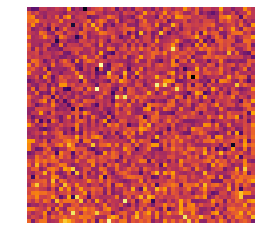

In [5]:
# load experimental image
aexp0 = np.fromfile(sworkdir + 'vac_3_avg.dat', dtype='float64').reshape(ndim)
rngc = np.array([[97, 151], [97, 154]])
aexp0c = aexp0[rngc[0,0]:rngc[0,1],rngc[1,0]:rngc[1,1]]
mexp0c = np.mean(aexp0c.reshape(aexp0c.size))
vexp0c = np.var(aexp0c.reshape(aexp0c.size))
texp0 = np.sum(aexp0)
aexp1 = aexp0 / texp0 # normalize to total intensity of 1 -> fit to this set of data
aexp1c = aexp1[rngc[0,0]:rngc[0,1],rngc[1,0]:rngc[1,1]]
mexp1c = np.mean(aexp1c.reshape(aexp1c.size))
vexp1c = np.var(aexp1c.reshape(aexp1c.size))
plotexpcenter = aplt.arrayplot2d(aexp0c, 4, 'inferno')
print("- total original counts:", texp0)
print("- original center (mean, std. dev., var.):", np.array([mexp0c, np.sqrt(vexp0c),vexp0c]))
print("- rescaled center (mean, std. dev., var.):", np.array([mexp1c, np.sqrt(vexp1c),vexp1c]))

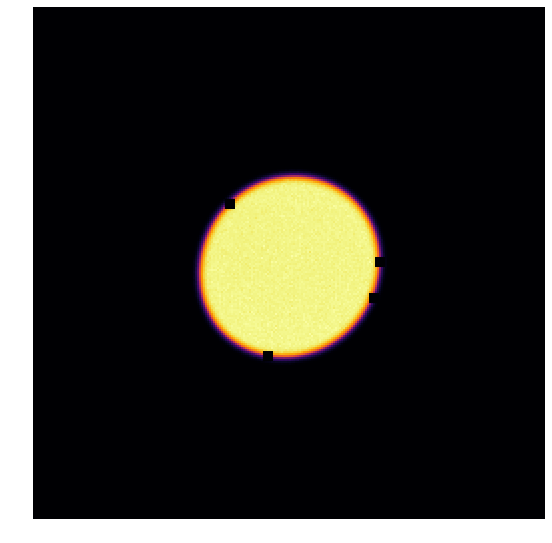

In [6]:
amsk0 = np.full(amtf.shape, 1)
amsk1 = amsk0
pmsk = np.array([[157,98,2],[110,170,2],[128,173,2],[81,117,2]]) # ! set pixel blocks to mask [col,row,size]
for i in range(0, pmsk.shape[0]):
    amsk1[pmsk[i,0]-pmsk[i,2]:pmsk[i,0]+pmsk[i,2]+1,pmsk[i,1]-pmsk[i,2]:pmsk[i,1]+pmsk[i,2]+1] = 0
plotmsk = aplt.arrayplot2d((aexp1*amsk1),2,'inferno')

Elapsed time [s] : 1.6175613403320312


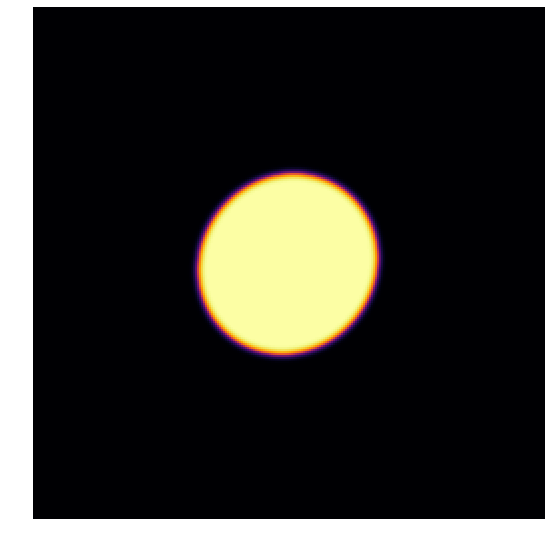

In [7]:
# test simulation
# - set parameters
apr = 11.95
aps = 0.3
#qd = np.array([0.150036, 0.376273, 0.0186035, 0.0277298, -0.00230719, 0.10082])
qd = np.array([0.15, 0.38, 0.0, 0.0, 0.0, 0.0])
# - calculate
start = time.time()
simulate_aperture(ar1,amtf,p0,sq2,q0,apr,aps,qd)
end = time.time()
print('Elapsed time [s] :' , (end - start))
# - plot
plota = aplt.arrayplot2d(ar1, 2, 'inferno')

[ 1.276460e+02  1.256330e+02  1.195770e+01  3.580600e-01  1.505240e-01
  3.761680e-01  1.858500e-02  2.768230e-02 -2.395300e-03  1.008192e-01]
Elapsed time [s] : 0.1406104564666748
chi-square : 1.9518175570071354e-08


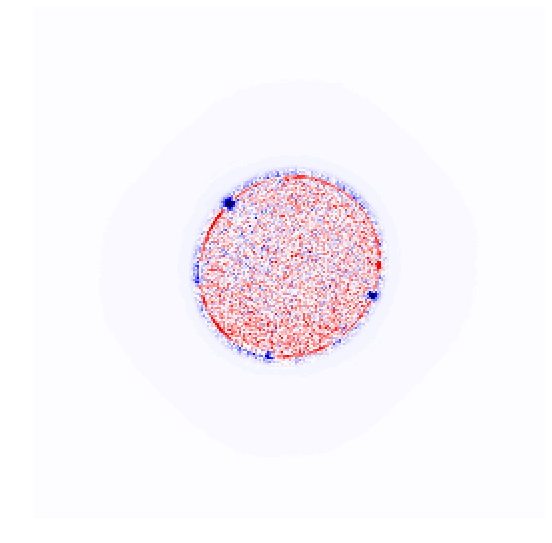

In [8]:
# test comparison
artmp = ar1
# - set parameters
p0 = np.array([127.646, 125.633])
apr = 11.9577
aps = 0.35806
qd = np.array([0.150524, 0.376168, 0.0185850, 0.0276823, -0.0023953, 0.1008192])
#qd = np.array([0.15, 0.38, 0.0, 0.0, 0.0, 0.0])
prmtmp = np.append(np.append(np.append(p0,apr),aps),qd)
print(prmtmp)
# - calculate
start = time.time()
chisq = aperture_image_sdif(aexp1, artmp, amsk1, amtf, sq2, prmtmp)
end = time.time()
print('Elapsed time [s] :' , (end - start))
print('chi-square :', chisq)
# - plot
adif = (aexp1 - artmp)
plota = aplt.arrayplot2d(adif, 2, 'seismic', vrangetype = 'direct', vrange = np.array([-1.e-5,1.e-5]))

In [ ]:
plota.savefig(sworkdir + 'vac_3_avg_sim_x.png', dpi=plota.dpi)

In [9]:
# prepare nelder mead optimization
from scipy.optimize import minimize
artmp = ar1
def nmcost(x):
    return aperture_image_sdif(aexp1, artmp, amsk1, amtf, sq2, x)

In [10]:
# Run a Nelder-Mead optimization
# This takes about 5 - 10 minutes and delivers a good result.
#
# setup parameters
prmnm0 = np.array([128.,128.,12.0,0.3,0.,0.,0.,0.,0.,0.]) # initial parameters
# setup simplex
prmnmd = np.array([1.,1.,1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1]) # initial parameter variation
prmnms = np.array(prmnm0) # initialize simplex
nprm = prmnm0.size
for i in range(0,nprm):
    prmdev = np.random.normal(size = nprm) * prmnmd
    prmnms = np.append(prmnms,prmnm0+prmdev)
prmnms = prmnms.reshape(nprm+1,nprm)
# run simplex
start = time.time()
nmsol = minimize(nmcost, prmnm0, method='nelder-mead',
                 options={'xatol': 1e-4, 'fatol': 1e-10, 'disp': True, 'adaptive': True, 'initial_simplex': prmnms})
end = time.time()
prmnmr = nmsol.x
chisq = nmsol.fun
print('Elapsed time [s]:', (end - start))
print('chi-square:', chisq)
print('best parameters:', prmnmr)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1337
         Function evaluations: 1963
Elapsed time [s]: 306.08829641342163
chi-square: 1.9356973572941573e-08
best parameters: [ 1.27646345e+02  1.25633265e+02  1.19518276e+01  3.18102995e-01
  1.50141430e-01  3.76266886e-01  1.84352287e-02  2.76590238e-02
 -2.71678576e-03  1.03744223e-01]


chi-square: 1.9356973572941573e-08
min: -2.6299745450361175e-05 , max:  7.786081670051191e-06


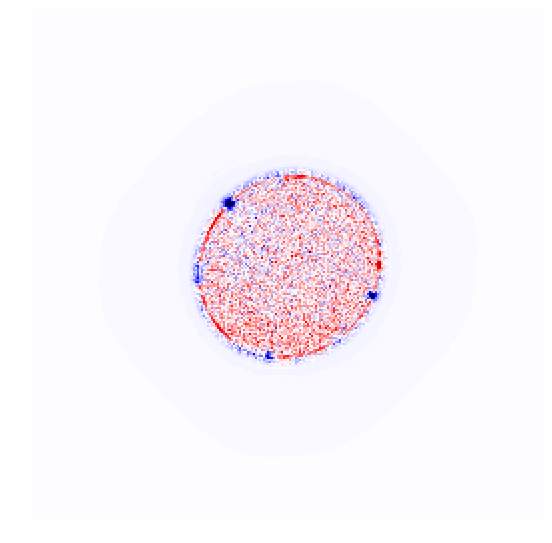

In [11]:
# display the result of the Nelder-Mead optimization
chisq = aperture_image_sdif(aexp1, artmp, amsk1, amtf, sq2, prmnmr)
adif = (aexp1 - artmp)
print('chi-square:', chisq)
print('min:', np.amin(adif), ', max: ', np.amax(adif))
plota = aplt.arrayplot2d(adif, 2, 'seismic', vrangetype = 'direct', vrange = np.array([-1.e-5,1.e-5]))

In [12]:
plota.savefig(sworkdir + 'vac_3_avg_sim_nelder-mead.png', dpi=plota.dpi)

In [ ]:
# below is experimental code. use with care

In [ ]:
# Monte-Carlo optimization
# This is experimental and will take some parameter tweaking to converge.
# - cycle over this and the 2 cells following below
# 
np.random.seed()
# - initial state
nprm = prmtmp.size
#prm0 = np.array([128.,128.,12.,0.2,0.,0.,0.,0.,0.,0.]) # <- use to initialize
prm0 = prmtmp # <- use when iterating
chisq0 = aperture_image_sdif(aexp1, artmp, amsk1, amtf, sq2, prm0)
print('initial:', prm0)
print('chi-square:', chisq0)
# - stepper
prmuse = np.array([1,1,1,1,1,1,1,1,1,1]) # flag parameters to optimize by 1, parameters to fix by 0
dstp = 0.01 # <- start with 0.01 and reduce when rejections are dominant
prms = np.array([1.,1.,1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1]) * dstp * prmuse
print('step ranges:', prms)
temp = chisq0 * 0.001 # - temperature # reduce when number of improves as much lower than possible improves
ntry = 200 # - number of useless trials
prmit = prm0
prmbest = prm0
csprev = chisq0
csbest = chisq0
nbest = 0
nbetter = 0
nprobacc = 0
it = 1
itsum = 1
pbar = tqdm(total=ntry)
pbar.update(1)
while it < ntry:
    prmdev = np.random.normal(size = nprm) * prms
    prmtry = prmit + prmdev
    cstry = aperture_image_sdif(aexp1, artmp, amsk1, amtf, sq2, prmtry)
    csdev = cstry - csprev
    if csdev <= 0: # improvement to previous?
        prmit = prmtry # update
        csprev = cstry # ''
        if (cstry < csbest): # even better than best ?
            prmbest = prmtry # update best
            csbest = cstry # ''
            nbest += 1
            it = 1 # reset iterator -> try to gat better at this temperature
            pbar.n = 1
            pbar.last_print_n = 1
        else:
            nbetter += 1
    else: # csdev > 0
        win = -csdev/temp
        probacc = 0.
        if win > -200:
            probacc = min(1., np.exp(win)) # finite probability to accept 0 ... 1
        if probacc > np.random.random_sample():
            prmit = prmtry # accept worse case
            csprev = cstry # ''
            nprobacc += 1
    it += 1
    itsum += 1
    pbar.set_description('({:d}) chisq: {:.4E}'.format(itsum, csbest))
    pbar.update(1)
pbar.close()
print('final:', prmbest)
print('change:', prmbest - prm0)
print('chi-square :', csbest, ', improvement: ', 1. - csbest/chisq0)
print('total trials:', itsum)
print('best:', nbest, ', better:', nbetter, ', probably better:', nprobacc, ', rejected: ', itsum - nbest - nbetter - nprobacc)


In [ ]:
# show comparison after M-C run
chisq = aperture_image_sdif(aexp1, artmp, amsk1, amtf, sq2, prmbest)
adif = (aexp1 - artmp)
print('chi-square:', chisq)
print('min:', np.amin(adif), ', max: ', np.amax(adif))
plota = aplt.arrayplot2d(adif, 2, 'seismic', vrangetype = 'direct', vrange = np.array([-1.e-5,1.e-5]))

In [ ]:
# copy parameters for iterating
prmtmp = prmbest